# Simple Machine-Learning: Boosted Regression Predictions
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 19, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/BRT_2D.ipynb

>📘 Learning Objectives
>
> 1. Understand the basics of prediction
> 2. Learn the format that your training data should be in
> 3. Learn to fit a Boosted Regression Tree
> 4. Evaluate fit
> 5. Make predictions with your model

::: {.callout-important}
# Important notes for this tutorial

### The functions are in a separate file

The Python functions for doing tasks, like prepping the data and plotting, are in a separate file `ml_utils.py` and the functions are imported with `import ml_utils as mu`. You will need to run the import code to have access to the functions.
:::

## Summary

In this tutorial we will predict a numerical variable (chl) using predictor variables, in this case hyperspectral Rrs, location and season. Our training data are the in-situ measurements of surface CHLA from Bio-Argo buoys. You can see how we downloaded the Argo data and got the PACE Rrs matchups in the files `argopy.ipnb` and `argopy-matchups.ipynb`.

$$
\hat{y} \sim f(Rrs, season, location)
$$

We will use a classic non-linear prediction model: boosted regression trees (BRTs). Trees learn a big collection of if-else rules that split the response variable space. BRTs are non-linear: they can learn complicated non-linear relationships. 

The goal is to create a predicted map of CHL given our predictor variables on a given day.

![BRT pred map](./Supporting_files/y_pred.png)

## Overview of the modeling steps

1. Create your sampling dataframe: spatial samples with response (what you are trying to predict), latitude, longitude, date.
2. Create your predictor dataframe. In this example we have an 3D cube (time, lat, lon) with all the Rrs, location and season variables and we sample from that.
3. Fit model
5. Make predictions

The hard part is the data prep. We need a dataframe that looks like this. Just showing the first 5 samples. `y` is what we are predicting and it is the true values we have (from some type of observation) and the variables to the right are what we train on. The ocean mask just tells up what to ignore (it's land).

| time       | lat   | lon   | y      | Rrs_370   | Rrs_400    | sin_time | cos_time | x_geo | y_geo | z_geo  | 
| ---------- | ----- | ----- | ------ | ----- | ----- | -------- | -------- | ----- | ----- | ------ | 
| 2020-07-03 | 12.25 | 63.50 | -1.273 | 27.84 | 34.82 | 0.017    | 1.000    | 0.431 | 0.904 | 0.212  |
| 2020-01-15 | 28.75 | 74.25 | -0.522 | 24.11 | 35.21 | -0.142   | -0.990   | 0.257 | 0.932 | 0.482  | 
| 2020-03-28 | -2.00 | 88.75 | -2.004 | 29.47 | 34.55 | 0.651    | 0.759    | 0.030 | 0.999 | -0.035 | 
| 2020-10-09 | 5.75  | 59.25 | -1.618 | 26.33 | 34.90 | -0.843   | 0.538    | 0.504 | 0.863 | 0.100  | 
| 2020-12-22 | 17.50 | 46.50 | -0.931 | 22.88 | 35.40 | -0.149   | -0.989   | 0.675 | 0.737 | 0.300  | 


## Variables in the model

A nice thing about BRTs is that we do not need to normalize (standardize) our predictor variables. BRTs work by splitting our predictors and normalizing has no effect. This is different than many other types of models that will perform much better with normalization.

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `Rrs_wav`     | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric                |
| `solar_hour` | ❌ Same across lat/lon   | ✅ Varies by time   | Hour |
| `y` (log CHL) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric  |


- **`Rrs`**: Hyperspectral Rrs is our core predictor variables. 
  
- **`solar_hour`**: Since bio-Argo CHLA is highly affected by time of day. 

- **`y` (response)**: The model trains on this. For our model it is logged CHL and it is roughly centered near 0.


*Note, neither bathymetry nor distance from coast improved the model by any appreciable amount over the model we use here. SST (upwelling signal) and salinity (river outflow signal) are highly correlated with chlorophyll in this region with strong seasonal patterns.* 


## Dealing with NaNs

In our application, NaNs in y (in our case CHL) appear over land and when obscured by clouds. Our BRT fitting function needs us to remove any rows in our dataframe where y is NaN. NaNs in our predictor variables are less common, but can happen. BRTs functions typically filter out any training data that have NaNs in the predictor variables so we will ignore those NaNs. We just have to make sure that missing values, or areas to ignore like land or cloud are coded as NaN and not something like -99.


## Load the libraries

* core data handling and plotting libraries
* our custom functions in `ml_utils.py`

In [3]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
# !pip install zarr gcsfs --quiet

In [1]:
# --- Core data handling and plotting libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import matplotlib.pyplot as plt  # for creating plots
import pandas as pd
import cartopy.crs as ccrs
import sklearn

In [2]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

# Load the Bio-Argo training data

In [4]:
# Load data from GitHub
import pandas as pd
import numpy as np

base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/"
url = f"{base_url}chla_argo_rss.parquet"
dataset = pd.read_parquet(url)
# IMPORTANT! log our response so it is symmetric (Normal-ish)
dataset = dataset.where(dataset["y"] > 0)
dataset["y"] = np.log(dataset["y"])
dataset = dataset.dropna(subset=["y"]) # drop nan
# Add solar_hour
dataset = mu.add_solar_time_features_df(dataset)
dataset

,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719,solar_hour,solar_sin_time,solar_cos_time
0,2024-03-05 01:16:05+00:00,29.062498,-17.229162,-0.125608,29.082600,-17.213600,0.006416,0.006900,0.007244,0.007086,...,0.000214,0.000214,0.000196,0.000174,0.000166,0.000160,0.000214,0.119445,0.031265,0.999511
1,2024-03-06 14:48:36.002000128+00:00,-19.562504,1.229172,-3.862305,-19.579800,1.223800,0.009774,0.010156,0.010510,0.010670,...,0.000018,0.000026,0.000028,0.000016,-0.000006,-0.000062,-0.000094,14.891945,-0.686823,-0.726824
2,2024-03-06 19:59:32.002000128+00:00,18.645832,-156.104172,-2.527181,18.641800,-156.094300,0.009662,0.009998,0.010172,0.010452,...,0.000118,0.000116,0.000116,0.000112,0.000108,0.000092,0.000074,9.585278,0.590899,-0.806745
3,2024-03-07 14:17:38.002000128+00:00,-58.729172,136.020844,-1.271144,-58.739200,136.018600,0.012482,0.012338,0.012580,0.012652,...,0.000210,0.000204,0.000194,0.000204,0.000212,0.000146,0.000020,23.361944,-0.166267,0.986081
4,2024-03-07 18:01:17.002000128+00:00,17.645832,-46.020828,-4.698907,17.666500,-46.015500,0.014870,0.015156,0.015466,0.015632,...,0.000190,0.000184,0.000178,0.000178,0.000174,0.000186,0.000192,14.953334,-0.698415,-0.715693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2025-09-30 01:02:16+00:00,51.270832,-153.937500,-0.508372,51.273800,-153.927000,0.003156,0.003722,0.004270,0.004040,...,0.000254,0.000246,0.000242,0.000234,0.000232,0.000136,0.000022,14.775278,-0.664307,-0.747460
2267,2025-09-30 11:24:00+00:00,-26.395836,-39.145828,-1.889152,-26.408567,-39.131625,0.008518,0.008746,0.008974,0.009030,...,0.000152,0.000148,0.000142,0.000140,0.000144,0.000146,0.000130,8.790278,0.744845,-0.667237
2268,2025-09-30 14:13:47.002000128+00:00,16.687498,-66.895828,-1.865722,16.670400,-66.916000,0.000246,0.000342,0.000558,0.000750,...,0.000116,0.000132,0.000124,0.000094,0.000050,-0.000096,-0.000158,9.770000,0.551209,-0.834367
2269,2025-09-30 00:52:20+00:00,13.270831,-20.604162,-3.045580,13.262400,-20.584500,0.005158,0.005668,0.005952,0.006066,...,0.000184,0.000178,0.000184,0.000178,0.000152,0.000102,0.000134,23.498611,-0.130887,0.991397


Here are where the samples are.

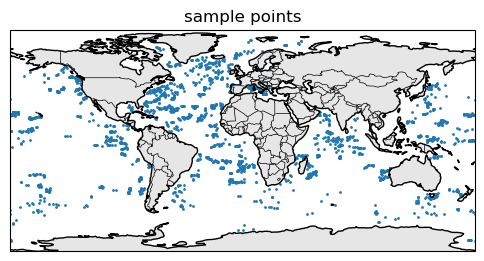

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(
    figsize=(6, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# coarse coastlines
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.scatter(dataset.lon, dataset.lat, s=1, transform=ccrs.PlateCarree())
ax.set_title("sample points")
plt.show()

## Create the train-test dataset

We will use `sklearn`'s split function.

In [25]:
from sklearn.model_selection import train_test_split

# Columns to exclude from predictors
cols_to_drop = ["y", "time", "lat", "lon", "df_lat", "df_lon", "solar_sin_time", "solar_cos_time"]
y = dataset["y"] # target
X = dataset.drop(columns=cols_to_drop, errors="ignore") # predictors

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

## Fit a BRT

In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

brt_model = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.05, max_iter=400,
    validation_fraction=0.1, early_stopping=True, random_state=42
).fit(X_train, y_train)

In [8]:
y_pred = brt_model.predict(X_train)
residuals = y_train - y_pred
df_map = dataset.loc[y_train.index, ["lat", "lon", "time"]]
df_map["y"] = y_train
df_map["y_pred"] = y_pred
df_map["residual"] = residuals

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def residual_plot(df_map):
    fig, ax = plt.subplots(
        figsize=(7,5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # symmetric limits around 0
    res = df_map["residual"].values
    max_abs = np.nanmax(np.abs(res))
    vmin, vmax = -max_abs, max_abs
    
    ax.coastlines(resolution="110m")
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    sc = ax.scatter(
        df_map["lon"],
        df_map["lat"],
        c=df_map["residual"],
        cmap="coolwarm",
        s=6,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    
    plt.colorbar(sc, ax=ax, label="Residual (y - y_pred)")
    bias = df_map["residual"].mean()
    plt.title(f"Residual Map (mean bias = {bias:.3f})")
    plt.show()


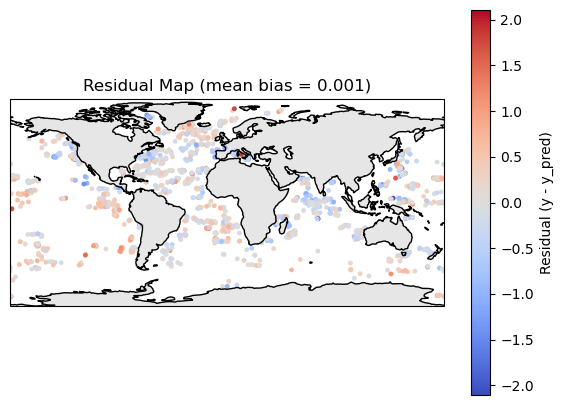

In [10]:
residual_plot(df_map)

## Compare to the test data

In [13]:
y_pred = brt_model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.7783028574722393
RMSE: 0.5036005435581484


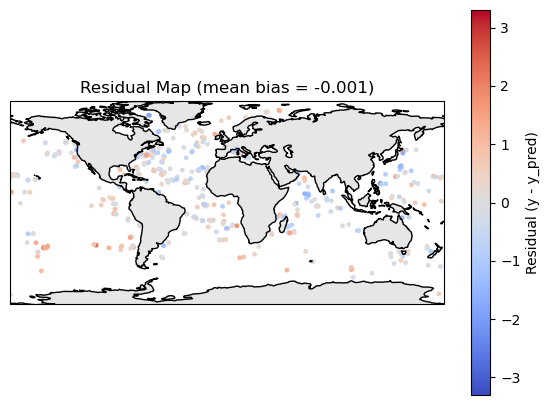

In [14]:
y_pred = brt_model.predict(X_test)
residuals = y_test - y_pred
df_map = dataset.loc[y_test.index, ["lat", "lon", "time"]]
df_map["y"] = y_test
df_map["y_pred"] = y_pred
df_map["residual"] = residuals
residual_plot(df_map)

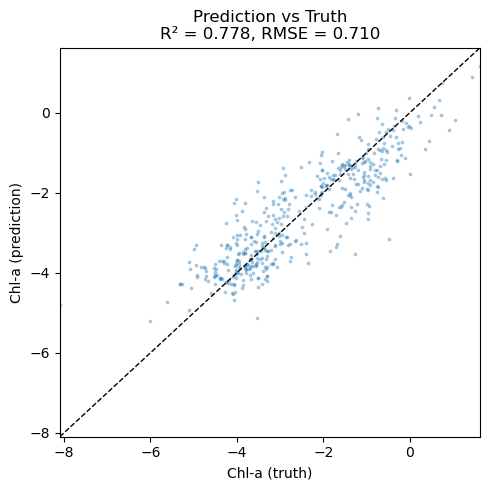

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

y_true = y_test

# Compute some metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Chl-a (truth)")
plt.ylabel("Chl-a (prediction)")
plt.title(f"Prediction vs Truth\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.tight_layout()
plt.show()

## Make a prediction of the whole region

To make a prediction, we use the `predict` attribute for the brt model object. It needs the predictor variables in rows rather than like a lat/lon map and we need to deal with all the NaNs in Rrs data. I create 2 functions:
* `make_prediction()` takes a xarray DataArray of Rrs. So like `ds["Rrs"]`.
* `make_plot()` takes a xarray DataArray of predictions from `make_prediction()` and optionally a data array of chla to compare to our predictions. So like `ds["chlora"]`.


In [36]:
import xarray as xr
def make_prediction(R: xr.Dataset, brt_model, feature_cols, solar_const=0):
    # --- 3. Stack lat/lon into a single "pixel" dimension ---
    R2 = R.stack(pixel=("lat", "lon"))  # (pixel, wavelength)
    R2 = R2.transpose("pixel", "wavelength")
    # Load this subset into memory
    R2_vals = R2.values  # shape: (n_pixel, n_wavelength)

    # --- 4. Make predictions dataframe
    # If the model expects solar_hour, add it as a constant column
    if "solar_hour" in feature_cols:
        wave_cols = [c for c in feature_cols if c != "solar_hour"]
        df_pred = pd.DataFrame(R2_vals, columns=wave_cols)
        df_pred["solar_hour"] = solar_const
        df_pred = df_pred[feature_cols]
    else:
        df_pred = pd.DataFrame(R2_vals, columns=feature_cols)

    # --- 5. Handle NaNs: BRTs generally cannot handle NaNs in predictors ---
    # Rrs dataset will have loads of NaNs
    valid_mask = ~df_pred.isna().any(axis=1)  # pixels with all bands present
    df_valid = df_pred[valid_mask]
    
    # Prepare an array for predictions (fill NaNs where we cannot predict)
    y_pred_flat = np.full(df_pred.shape[0], np.nan, dtype=float)
    
    # --- 6. Predict on the valid pixels ---
    if len(df_valid) > 0:
        y_pred_flat[valid_mask.values] = brt_model.predict(df_valid)

    # --- 7. Reshape back to (lat, lon) ---
    nlat = R.sizes["lat"]
    nlon = R.sizes["lon"]
    pred_map = y_pred_flat.reshape(nlat, nlon)
    
    pred_da = xr.DataArray(
        pred_map,
        coords={"lat": R["lat"], "lon": R["lon"]},
        dims=("lat", "lon"),
        name="y_pred"
    )

    return pred_da

In [37]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def make_plot(
    pred_da: xr.DataArray,
    true_da: xr.DataArray | None = None,
    diff: bool = True,
    shared_colorbar: bool = True,
    true_label: str = "PACE Chlorophyll",
    pred_label: str = "BRT prediction",
    cmap_pred: str = "viridis",
):
    """
    Plot prediction, optionally with truth and difference.

    Parameters
    ----------
    pred_da : xr.DataArray
        Prediction on a lat/lon grid.
    true_da : xr.DataArray or None
        Truth on the same lat/lon grid. If None, only pred is plotted.
 #   diff : bool, default True
        If True and true_da is provided, add a third panel with pred - truth.
    shared_colorbar : bool, default True
        If True, use one colorbar for truth+prediction panels.
    """
    # -----------------------
    # Case 1: only prediction
    # -----------------------
    if true_da is None:
        # robust-ish limits from prediction only
        vals = pred_da.values.ravel()
        vmin, vmax = np.nanpercentile(vals, (0, 100))

        fig, ax = plt.subplots(
            1, 1,
            figsize=(6, 4),
            subplot_kw={"projection": ccrs.PlateCarree()},
            constrained_layout=True,
        )

        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor="0.9")

        im = ax.pcolormesh(
            pred_da["lon"],
            pred_da["lat"],
            pred_da,
            transform=ccrs.PlateCarree(),
           vmin=vmin, vmax=vmax,
            cmap=cmap_pred,
        )

        ax.set_title(pred_label)
        cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.06, pad=0.08)
        cbar.set_label(pred_label)
        plt.show()
        return

    # ------------------------------------------------
    # Case 2: truth + prediction (+/- difference)
    # ------------------------------------------------
    if diff:
        ncols = 3
    else:
        ncols = 2

    fig, axs = plt.subplots(
        1, ncols,
        figsize=(5 * ncols, 5),
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True,
    )

    if ncols == 1:
        axs = [axs]  # just in case, but here ncols>=2

    # 1. Compute robust-ish limits for truth & prediction
    all_vals = np.concatenate([
        true_da.values.ravel(),
        pred_da.values.ravel()
    ])
    vmin, vmax = np.nanpercentile(all_vals, (0, 100))

    # -------------------
    # Panel 1: Truth
    # -------------------
    ax = axs[0]
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")
    im_truth = ax.pcolormesh(
        true_da["lon"],
        true_da["lat"],
        true_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap_pred,
    )
    ax.set_title(true_label)

    # -------------------
    # Panel 2: Prediction
    # -------------------
    ax = axs[1]
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")
    im_pred = ax.pcolormesh(
        pred_da["lon"],
        pred_da["lat"],
        pred_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap_pred,
    )
    ax.set_title(pred_label)

    # -------------------
    # Panel 3: Difference (optional)
    # -------------------
    if diff:
        diff_da = true_da - pred_da

        # Symmetric limits for diff
        diff_vals = diff_da.values.ravel()
        diff_max = np.nanpercentile(np.abs(diff_vals), 98)
        diff_vmin, diff_vmax = -diff_max, diff_max

        ax = axs[2]
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor="0.9")
        im_diff = ax.pcolormesh(
            diff_da["lon"],
            diff_da["lat"],
            diff_da,
            transform=ccrs.PlateCarree(),
            vmin=diff_vmin,
            vmax=diff_vmax,
            cmap="coolwarm",
        )
        ax.set_title("PACE - BRT")

    # -------------------
    # Colorbars
    # -------------------
    if shared_colorbar:
        # one shared colorbar for truth + prediction
        cbar1 = fig.colorbar(
            im_pred,
            ax=axs[:2],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar1.set_label("Value")
    else:
        # separate colorbars for PACE and BRT
        cbar_t = fig.colorbar(
            im_truth,
            ax=axs[0],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar_t.set_label(true_label)

        cbar_p = fig.colorbar(
            im_pred,
            ax=axs[1],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar_p.set_label(pred_label)

    if diff:
        cbar2 = fig.colorbar(
            im_diff,
            ax=axs[-1],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar2.set_label("PACE - BRT")

    plt.show()


## Load PACE Rrs and Chla data

### First load Rrs since we use that for prediction

In [18]:
import earthaccess
import xarray as xr

day = "2024-07-05"

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

# Get chla
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(chl_results[0:1], pqdm_kwargs={"disable": True})
chl_ds = xr.open_dataset(f[0])
chl_ds["log_chla"] = np.log(chl_ds["chlor_a"])

## Make a prediction for North Atlantic

In [19]:
# Northwest Atlantic
# Set a box
lat_min, lat_max = 20, 60
lon_min, lon_max = -70, -40
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
R = R.transpose("lat", "lon", "wavelength")

# Get CHLA for that box
chla = chl_ds["log_chla"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
chla = chla.transpose("lat", "lon")

In [54]:
%%time
# Make prediction
feature_cols = list(X_train.columns)
pred_da = make_prediction(R, brt_model, feature_cols, solar_const=0)

CPU times: user 1.52 s, sys: 173 ms, total: 1.69 s
Wall time: 1.14 s


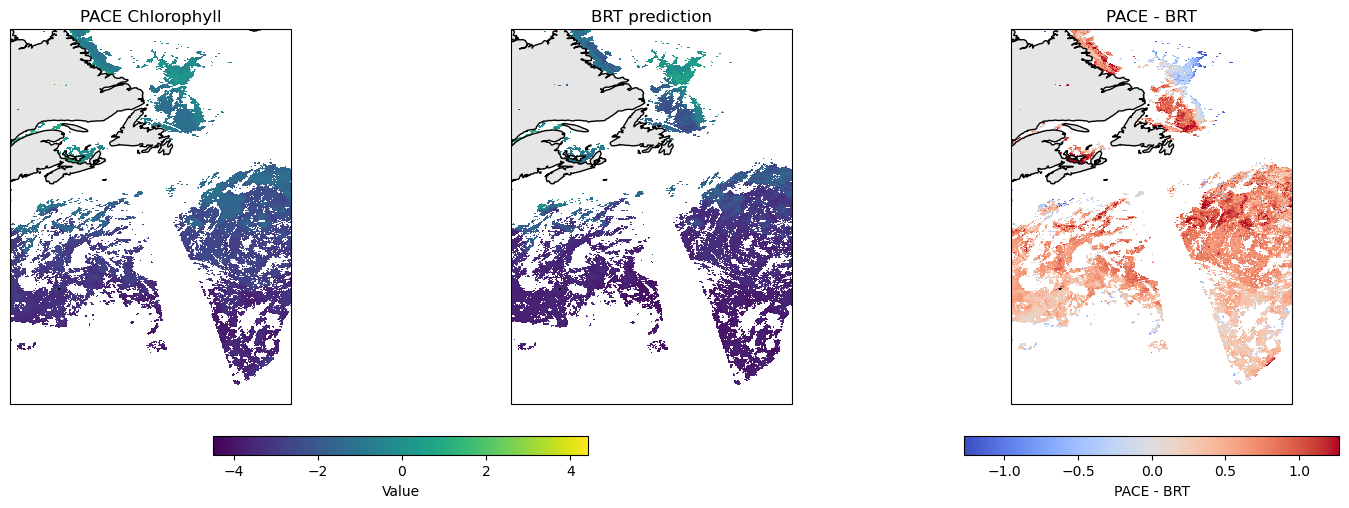

In [49]:
# Make a plot
make_plot(pred_da, chla)

## Scatter plot

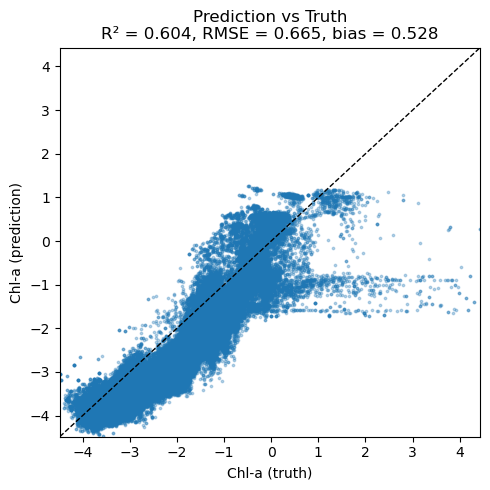

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Flatten and drop NaNs
y_true = chla.values.ravel()
y_pred = pred_da.values.ravel()

mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Compute some metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
bias = np.mean(y_true - y_pred)

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Chl-a (truth)")
plt.ylabel("Chl-a (prediction)")
plt.title(f"Prediction vs Truth\nR² = {r2:.3f}, RMSE = {rmse:.3f}, bias = {bias:.3f}")
plt.tight_layout()
plt.show()


In [55]:
# Northwest Atlantic
# Set a box
lat_min, lat_max = 20, 60
lon_min, lon_max = -70, 20
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
#R = R.isel(lat=slice(0, None, 10), lon=slice(0, None, 10)) # take every 4th lat and lon
R = R.transpose("lat", "lon", "wavelength")
# Get CHLA for that box
chla = chl_ds["log_chla"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
#chla = chla.isel(lat=slice(0, None, 10), lon=slice(0, None, 10)) # take every 4th lat and lon
chla = chla.transpose("lat", "lon")


In [56]:
%%time
# Make prediction
feature_cols = list(X_train.columns)
pred_da = make_prediction(R, brt_model, feature_cols)

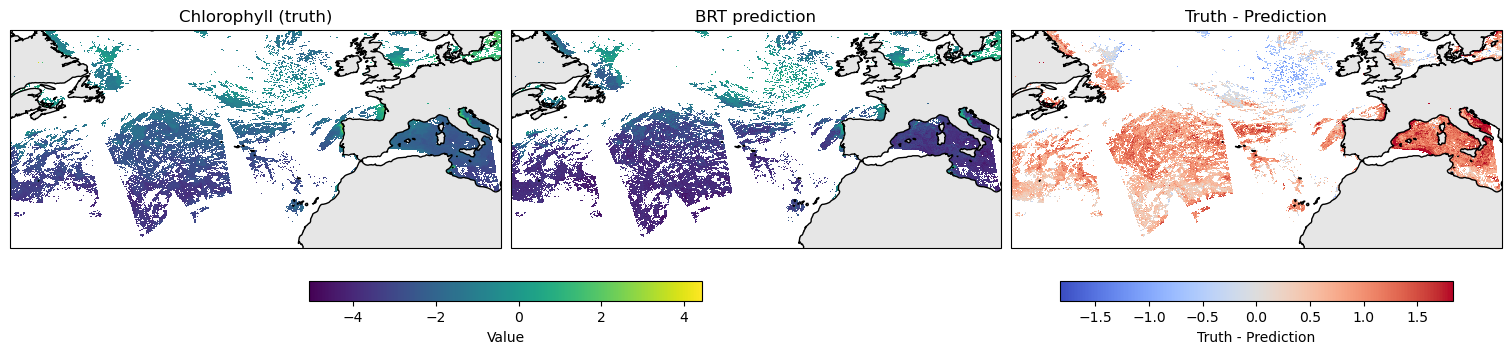

In [138]:
# Make a plot
make_plot(pred_da, chla)

## Accounting for the bias between bio-Argo and PACE Chl

bio-Argo is lower for a variety of reasons, like not being surface and different way of measuring chla.

$$
\widehat{\log(CHL_{PACE})} \sim \alpha \log(CHL_{BRT})+\gamma
$$

The bias at midnight, which is what is being assumed in the prediction is
$$
bias_m = \widehat{\log(CHL_{PACE})} - \log(CHL_{BRT})
$$

We can add that to our BRT predictions since our BRT prediction is $\widehat{\log(CHL_{BRT})}$ at midnight and that gives use PACE CHL prediction at midnight. 

argo is not surface for a variety of reasons. We can try to make our measurements more closely mimic surface by estimating the relationship between argo and pace (and solar hour). The get a CHLA_ADJUSTED that we use.

In [57]:
eps = 1e-6
df_valid["log_chl_midnight"] = np.log10(df_valid["chl_midnight_pred"] + eps)
df_valid["log_pace"] = np.log10(df_valid["pace_chlor_a"] + eps)
df_valid["solar_hour"] = df_valid["solar_hour"]  # but will mostly be ignored
import statsmodels.api as sm

X_lr = df_valid[["log_chl_midnight", "solar_hour"]]
X_lr = sm.add_constant(X_lr)
y_lr = df_valid["log_pace"]

lr_model = sm.OLS(y_lr, X_lr).fit()
print(lr_model.summary())
alpha = lr_model.params["log_chl_midnight"]
beta  = lr_model.params["solar_hour"]
gamma = lr_model.params["const"]

df_valid["expected_log_pace_midnight"] = (
    alpha * df_valid["log_chl_midnight"] + gamma
)

df_valid["expected_bias_midnight"] = (
    df_valid["expected_log_pace_midnight"] - df_valid["log_chl_midnight"]
)

NameError: name 'df_valid' is not defined

## Summary

You have fit a basic BRT with season and location information. It is a bit "stripy" which happens with location variables but it is not terrible.

Things you might try
* remove salinity and sst
* keep salinity and sst and remove season or location variables
* reduce the number of sample points from 10,000 to 1,000

In [1]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/"
url = f"{base_url}argo_bgc_global_surface_{df_y_name}.parquet"
df = pd.read_parquet(url)

# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.nc"
)
# all days since Mar 2024; pqdm args to quiet output
fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );
import xarray as xr
ds = xr.open_dataset(fileset[0])

In [2]:
# Get the lat/lon vals in df_day
df_lats = dataset["lat"].to_numpy(dtype=float)
df_lons = dataset["lon"].to_numpy(dtype=float)
df_lats.shape

(2201,)

In [4]:
dataset

,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_706,Rrs_707,Rrs_708,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719
0,2024-03-05 01:16:05+00:00,29.062498,-17.229162,-0.125608,29.082600,-17.213600,0.006416,0.006900,0.007244,0.007086,...,0.000218,0.000218,0.000224,0.000214,0.000214,0.000196,0.000174,0.000166,0.000160,0.000214
1,2024-03-06 14:48:36.002000128+00:00,-19.562504,1.229172,-3.862305,-19.579800,1.223800,0.009774,0.010156,0.010510,0.010670,...,0.000006,0.000006,0.000012,0.000018,0.000026,0.000028,0.000016,-0.000006,-0.000062,-0.000094
2,2024-03-06 19:59:32.002000128+00:00,18.645832,-156.104172,-2.527181,18.641800,-156.094300,0.009662,0.009998,0.010172,0.010452,...,0.000140,0.000130,0.000124,0.000118,0.000116,0.000116,0.000112,0.000108,0.000092,0.000074
3,2024-03-07 14:17:38.002000128+00:00,-58.729172,136.020844,-1.271144,-58.739200,136.018600,0.012482,0.012338,0.012580,0.012652,...,0.000232,0.000226,0.000220,0.000210,0.000204,0.000194,0.000204,0.000212,0.000146,0.000020
4,2024-03-07 18:01:17.002000128+00:00,17.645832,-46.020828,-4.698907,17.666500,-46.015500,0.014870,0.015156,0.015466,0.015632,...,0.000214,0.000202,0.000194,0.000190,0.000184,0.000178,0.000178,0.000174,0.000186,0.000192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2025-09-30 01:02:16+00:00,51.270832,-153.937500,-0.508372,51.273800,-153.927000,0.003156,0.003722,0.004270,0.004040,...,0.000274,0.000266,0.000258,0.000254,0.000246,0.000242,0.000234,0.000232,0.000136,0.000022
2267,2025-09-30 11:24:00+00:00,-26.395836,-39.145828,-1.889152,-26.408567,-39.131625,0.008518,0.008746,0.008974,0.009030,...,0.000170,0.000166,0.000160,0.000152,0.000148,0.000142,0.000140,0.000144,0.000146,0.000130
2268,2025-09-30 14:13:47.002000128+00:00,16.687498,-66.895828,-1.865722,16.670400,-66.916000,0.000246,0.000342,0.000558,0.000750,...,0.000082,0.000098,0.000110,0.000116,0.000132,0.000124,0.000094,0.000050,-0.000096,-0.000158
2269,2025-09-30 00:52:20+00:00,13.270831,-20.604162,-3.045580,13.262400,-20.584500,0.005158,0.005668,0.005952,0.006066,...,0.000230,0.000212,0.000194,0.000184,0.000178,0.000184,0.000178,0.000152,0.000102,0.000134


In [21]:
%%time
pts_all = []
for res in results:
    df_record, pts = mu.one_file_matches(res, dataset, ds_vec_name=None, ds_var_name="chlor_a")
    pts_all.append(pts)
pts_all = pd.concat(pts_all, ignore_index=True)

CPU times: user 1.08 s, sys: 173 ms, total: 1.25 s
Wall time: 15.2 s


In [23]:
15*560/(60*5)

28.0

In [22]:
import numpy as np
pts_all["chlor_a"] = np.log(pts_all["chlor_a"])
pts_all

,time,lat,lon,y,df_lat,df_lon,chlor_a
0,2024-03-05 01:16:05+00:00,29.062498,-17.229162,-0.125608,29.062498,-17.229162,-1.327262
1,2024-03-06 14:48:36.002000128+00:00,-19.562504,1.229172,-3.862305,-19.562504,1.229172,-2.858074
2,2024-03-06 19:59:32.002000128+00:00,18.645832,-156.104172,-2.527181,18.645832,-156.104172,-2.618263
3,2024-03-07 14:17:38.002000128+00:00,-58.729172,136.020844,-1.271144,-58.729172,136.020844,-2.480719
4,2024-03-07 18:01:17.002000128+00:00,17.645832,-46.020828,-4.698907,17.645832,-46.020828,-3.296435
5,2024-03-07 12:53:45.049999872+00:00,11.562498,-24.770828,-3.048079,11.562498,-24.770828,-1.962292
6,2024-03-07 12:47:51.996000+00:00,55.187500,14.520839,-0.942263,55.187500,14.520839,-0.063714
7,2024-03-08 01:17:47.019000064+00:00,-5.520836,71.770844,-3.228926,-5.520836,71.770844,NaN
8,2024-03-08 23:44:40.003000064+00:00,-35.937504,-157.520828,-5.002526,-35.937504,-157.520828,-3.961531
9,2024-03-08 21:35:51.002000128+00:00,-23.520836,1.104172,-3.314179,-23.520836,1.104172,-3.365818
